# Linking SCE utility data with building polygons
This notebook will take Global Building Atlas polygons and link to the nearest SCE feeder line.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import MultiLineString
import matplotlib.pyplot as plt
import glob
import os
import folium

In [2]:
pd.set_option('display.max_columns', None)

In [ ]:
# Create bbox for small, pilot area in Los Angeles County
bbox = box(minx=-118.214971, miny=33.936380, maxx=-118.169223, maxy=33.954822)
bbox = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326")

In [4]:
# Convert to projected crs
bbox = bbox.to_crs(epsg=3310)

# 1. SCE Circuit Segments

In [5]:
sce_circ_segments = gpd.read_file("../../../../capstone/electrigrid/data/utilities/sce_circuits/ICA_-_Circuit_Segments.geojson", bbox=bbox)

In [6]:
sce_circ_segments.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
# Convert to projected crs
sce_circ_segments = sce_circ_segments.to_crs(epsg=3310)

In [8]:
# Clip circuits to bbox
sce_circ_segments = gpd.clip(sce_circ_segments, bbox)
sce_circ_segments.head()

,download_link_microgrid,changed_date,lgp_flag,most_limiting_factor,circuit_name,section_id,node_id,phase,circuit_voltage,substation_name,substation_voltage,system_name,ica_overall_load,ica_overall_pv_op_flex,ica_overall_pv,uniform_generation_op_flex,uniform_generation,note,download_link,disclaimer,objectid,Shape__Length,geometry
671,https://Microgrid.sce.com/icafiledownload/mode...,04/08/2025,No,Generation - Steady State Voltage,Tweedy,54675250,18386746,3,4,Lynwood,16/4 kV,Lighthipe 220/66 System,0,0,0.0,0,0.0000,None,https://drpep.sce.com/icafiledownload/models/w...,N,174605,1577.325429,"LINESTRING (165199.276 -451666.539, 165189.827..."
503,https://Microgrid.sce.com/icafiledownload/mode...,04/08/2025,No,Generation - Steady State Voltage,Parafine,188735724,17465662,3,16,Cudahy,66/16 kV,Laguna Bell 220/66 System,0,1.0932,1.0,.5139,0.5139,None,https://drpep.sce.com/icafiledownload/models/w...,N,158705,9.233587,"LINESTRING (165257.162 -451607.120, 165254.350..."
657,https://Microgrid.sce.com/icafiledownload/mode...,04/08/2025,No,Generation - Steady State Voltage,Parafine,17467755,188735711,3,16,Cudahy,66/16 kV,Laguna Bell 220/66 System,0,1.0932,1.0,.5139,0.5139,None,https://drpep.sce.com/icafiledownload/models/w...,N,158915,71.198657,"LINESTRING (165281.972 -451592.584, 165263.567..."
670,https://Microgrid.sce.com/icafiledownload/mode...,04/08/2025,No,Generation - Steady State Voltage,Tweedy,18447164,18405974,3,4,Lynwood,16/4 kV,Lighthipe 220/66 System,0,0,0.0,0,0.0000,None,https://drpep.sce.com/icafiledownload/models/w...,N,174604,385.770361,"LINESTRING (165216.612 -451562.289, 165169.875..."
506,https://Microgrid.sce.com/icafiledownload/mode...,04/08/2025,No,Generation - Steady State Voltage,Parafine,17504013,17437584,3,16,Cudahy,66/16 kV,Laguna Bell 220/66 System,0,1.0499,1.0,.4936,0.4936,None,https://drpep.sce.com/icafiledownload/models/w...,N,158708,127.089069,"LINESTRING (165283.860 -451574.384, 165322.188..."


# 1a. SCE Customer Table

Retrieved from: [ICA Tables Layer](https://drpep-sce2.opendata.arcgis.com/maps/f76174d459a14545b2b13110d1cc6fba/about)

In [9]:
sce_table = pd.read_csv("../../../../capstone/electrigrid/data/utilities/sce_circuits/ICA_Single_Consolidated_Table.csv")
sce_table.head()

,circuit_name,circuit_id,circuit_voltage,percent_15_cap,res_pct,com_pct,agr_pct,other_pct,ind_pct,sub_name,subst_id,note_sub,layer_identifier,sys_name,existing_gen,queued_gen,total_gen,projected_load,penetration_level,max_remain_cap,agr_total,com_total,ind_total,res_total,other_total,OBJECTID
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jose,1060.0,Interconnection studies in this area have iden...,ESRI_DRP_SUBSTATION_T_DRP,Rio Hondo 220/66 System,0.0,0.0,0.0,5.00,0.0,5.0,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Julian Hinds,235.0,Interconnection studies in this area have iden...,ESRI_DRP_SUBSTATION_T_DRP,Mwd 220/220 System,0.0,0.0,0.0,0.00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Glow,2172.0,Interconnection studies in this area have iden...,ESRI_DRP_SUBSTATION_T_DRP,Antelope 220/66 System,0.0,0.0,0.0,0.00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,3
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Growers,2280.0,Interconnection studies in this area have iden...,ESRI_DRP_SUBSTATION_T_DRP,Vestal 220/66 System,0.0,0.0,0.0,0.00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,4
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Haagen,1149.0,Interconnection studies in this area have iden...,ESRI_DRP_SUBSTATION_T_DRP,Rector 220/66 System,0.0,0.0,0.0,4.79,0.0,5.6,NaN,NaN,NaN,NaN,NaN,5


In [10]:
sce_table = sce_table.dropna(subset=['circuit_name'])
sce_table.head()

,circuit_name,circuit_id,circuit_voltage,percent_15_cap,res_pct,com_pct,agr_pct,other_pct,ind_pct,sub_name,subst_id,note_sub,layer_identifier,sys_name,existing_gen,queued_gen,total_gen,projected_load,penetration_level,max_remain_cap,agr_total,com_total,ind_total,res_total,other_total,OBJECTID
1286,Abacus,2131371.0,12.0,0.0,76.59,7.60,0.00,15.81,0.00,Highland,NaN,NaN,ESRI_CIRCUIT_3_T_DRP,San Bernardino 220/66 System,2.272,2.344,4.615,8.26,55.86,5.38,0.0,62.0,0.0,625.0,129.0,1287
1287,Abana,2104017.0,12.0,1.0,13.85,62.31,0.00,23.08,0.77,Greening,NaN,NaN,ESRI_CIRCUIT_3_T_DRP,Del Amo 220/66 System,0.423,0.017,0.440,9.58,4.59,9.56,0.0,81.0,1.0,18.0,30.0,1288
1288,Abbey,2104018.0,12.0,0.0,43.39,4.24,12.72,39.65,0.00,Bliss,NaN,NaN,ESRI_CIRCUIT_3_T_DRP,Springville 220/66 System,0.347,3.151,3.498,3.80,91.93,6.50,51.0,17.0,0.0,174.0,159.0,1289
1289,Abbot,2140851.0,12.0,0.0,72.22,17.80,0.00,9.99,0.00,Ellis,NaN,NaN,ESRI_CIRCUIT_3_T_DRP,Ellis 220/66 System,1.185,0.065,1.250,7.82,15.98,8.75,0.0,139.0,0.0,564.0,78.0,1290
1290,Aberdeen,2140852.0,12.0,0.0,71.43,12.83,0.00,15.74,0.00,Bovine,NaN,NaN,ESRI_CIRCUIT_3_T_DRP,Del Amo 220/66 System,0.996,0.062,1.058,6.25,16.91,8.94,0.0,53.0,0.0,295.0,65.0,1291


In [11]:
sce_segments_table = pd.merge(left=sce_circ_segments, right=sce_table, how='left', on='circuit_name')
sce_segments_table.head()

,download_link_microgrid,changed_date,lgp_flag,most_limiting_factor,circuit_name,section_id,node_id,phase,circuit_voltage_x,substation_name,substation_voltage,system_name,ica_overall_load,ica_overall_pv_op_flex,ica_overall_pv,uniform_generation_op_flex,uniform_generation,note,download_link,disclaimer,objectid,Shape__Length,geometry,circuit_id,circuit_voltage_y,percent_15_cap,res_pct,com_pct,agr_pct,other_pct,ind_pct,sub_name,subst_id,note_sub,layer_identifier,sys_name,existing_gen,queued_gen,total_gen,projected_load,penetration_level,max_remain_cap,agr_total,com_total,ind_total,res_total,other_total,OBJECTID
0,https://Microgrid.sce.com/icafiledownload/mode...,04/08/2025,No,Generation - Steady State Voltage,Tweedy,54675250,18386746,3,4,Lynwood,16/4 kV,Lighthipe 220/66 System,0,0,0.0,0,0.0000,None,https://drpep.sce.com/icafiledownload/models/w...,N,174605,1577.325429,"LINESTRING (165199.276 -451666.539, 165189.827...",2188191.0,4.0,0.10,72.79,10.88,0.0,16.33,0.00,Lynwood,NaN,NaN,ESRI_CIRCUIT_3_T_DRP,Lighthipe 220/66 System,0.157,0.000,0.157,1.71,9.18,2.14,0.0,32.0,0.0,214.0,48.0,5411
1,https://Microgrid.sce.com/icafiledownload/mode...,04/08/2025,No,Generation - Steady State Voltage,Parafine,188735724,17465662,3,16,Cudahy,66/16 kV,Laguna Bell 220/66 System,0,1.0932,1.0,.5139,0.5139,None,https://drpep.sce.com/icafiledownload/models/w...,N,158705,9.233587,"LINESTRING (165257.162 -451607.120, 165254.350...",2189857.0,16.0,0.65,56.16,19.51,0.0,23.30,1.04,Cudahy,NaN,NaN,ESRI_CIRCUIT_3_T_DRP,Laguna Bell 220/66 System,0.709,0.218,0.927,10.52,8.81,12.27,0.0,206.0,11.0,593.0,246.0,4232
2,https://Microgrid.sce.com/icafiledownload/mode...,04/08/2025,No,Generation - Steady State Voltage,Parafine,17467755,188735711,3,16,Cudahy,66/16 kV,Laguna Bell 220/66 System,0,1.0932,1.0,.5139,0.5139,None,https://drpep.sce.com/icafiledownload/models/w...,N,158915,71.198657,"LINESTRING (165281.972 -451592.584, 165263.567...",2189857.0,16.0,0.65,56.16,19.51,0.0,23.30,1.04,Cudahy,NaN,NaN,ESRI_CIRCUIT_3_T_DRP,Laguna Bell 220/66 System,0.709,0.218,0.927,10.52,8.81,12.27,0.0,206.0,11.0,593.0,246.0,4232
3,https://Microgrid.sce.com/icafiledownload/mode...,04/08/2025,No,Generation - Steady State Voltage,Tweedy,18447164,18405974,3,4,Lynwood,16/4 kV,Lighthipe 220/66 System,0,0,0.0,0,0.0000,None,https://drpep.sce.com/icafiledownload/models/w...,N,174604,385.770361,"LINESTRING (165216.612 -451562.289, 165169.875...",2188191.0,4.0,0.10,72.79,10.88,0.0,16.33,0.00,Lynwood,NaN,NaN,ESRI_CIRCUIT_3_T_DRP,Lighthipe 220/66 System,0.157,0.000,0.157,1.71,9.18,2.14,0.0,32.0,0.0,214.0,48.0,5411
4,https://Microgrid.sce.com/icafiledownload/mode...,04/08/2025,No,Generation - Steady State Voltage,Parafine,17504013,17437584,3,16,Cudahy,66/16 kV,Laguna Bell 220/66 System,0,1.0499,1.0,.4936,0.4936,None,https://drpep.sce.com/icafiledownload/models/w...,N,158708,127.089069,"LINESTRING (165283.860 -451574.384, 165322.188...",2189857.0,16.0,0.65,56.16,19.51,0.0,23.30,1.04,Cudahy,NaN,NaN,ESRI_CIRCUIT_3_T_DRP,Laguna Bell 220/66 System,0.709,0.218,0.927,10.52,8.81,12.27,0.0,206.0,11.0,593.0,246.0,4232


# 2. Global Building Atlas Buildings

In [12]:
path = "../../../../capstone/electrigrid/data/buildings/w120_n35_w115_n30.parquet"
buildings = gpd.read_parquet(path)

In [13]:
buildings.crs

<Geographic 2D CRS: OGC:CRS84>
Name: WGS 84 (CRS84)
Axis Info [ellipsoidal]:
- Lon[east]: Geodetic longitude (degree)
- Lat[north]: Geodetic latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
# Convert buildings crs & clip to bbox
buildings = buildings.to_crs(epsg=3310)
buildings_clip = gpd.clip(buildings, bbox)

In [15]:
buildings_clip.head()

,source,id,height,var,region,bbox,geometry
4573022,ms,UnitedStates_023012311_832219,2.387687,0.517549,USA,"{'xmin': -118.1729984496768, 'ymin': 33.936795...","POLYGON ((168919.301 -451531.981, 168921.215 -..."
4573023,ms,UnitedStates_023012311_307170,0.439230,0.160512,USA,"{'xmin': -118.17212533361956, 'ymin': 33.93705...","POLYGON ((168991.534 -451497.439, 168997.341 -..."
4607921,ms,UnitedStates_023012311_1217650,2.483286,0.699443,USA,"{'xmin': -118.1722285390422, 'ymin': 33.937674...","POLYGON ((168990.369 -451450.755, 168980.975 -..."
4607922,ms,UnitedStates_023012311_171473,4.941268,1.518147,USA,"{'xmin': -118.17301420371393, 'ymin': 33.93831...","POLYGON ((168916.481 -451359.233, 168926.537 -..."
4607923,ms,UnitedStates_023012311_981135,5.603391,0.418036,USA,"{'xmin': -118.1727764737718, 'ymin': 33.938924...","POLYGON ((168943.109 -451312.981, 168927.656 -..."


# Plot buildings and grid together

<Axes: >

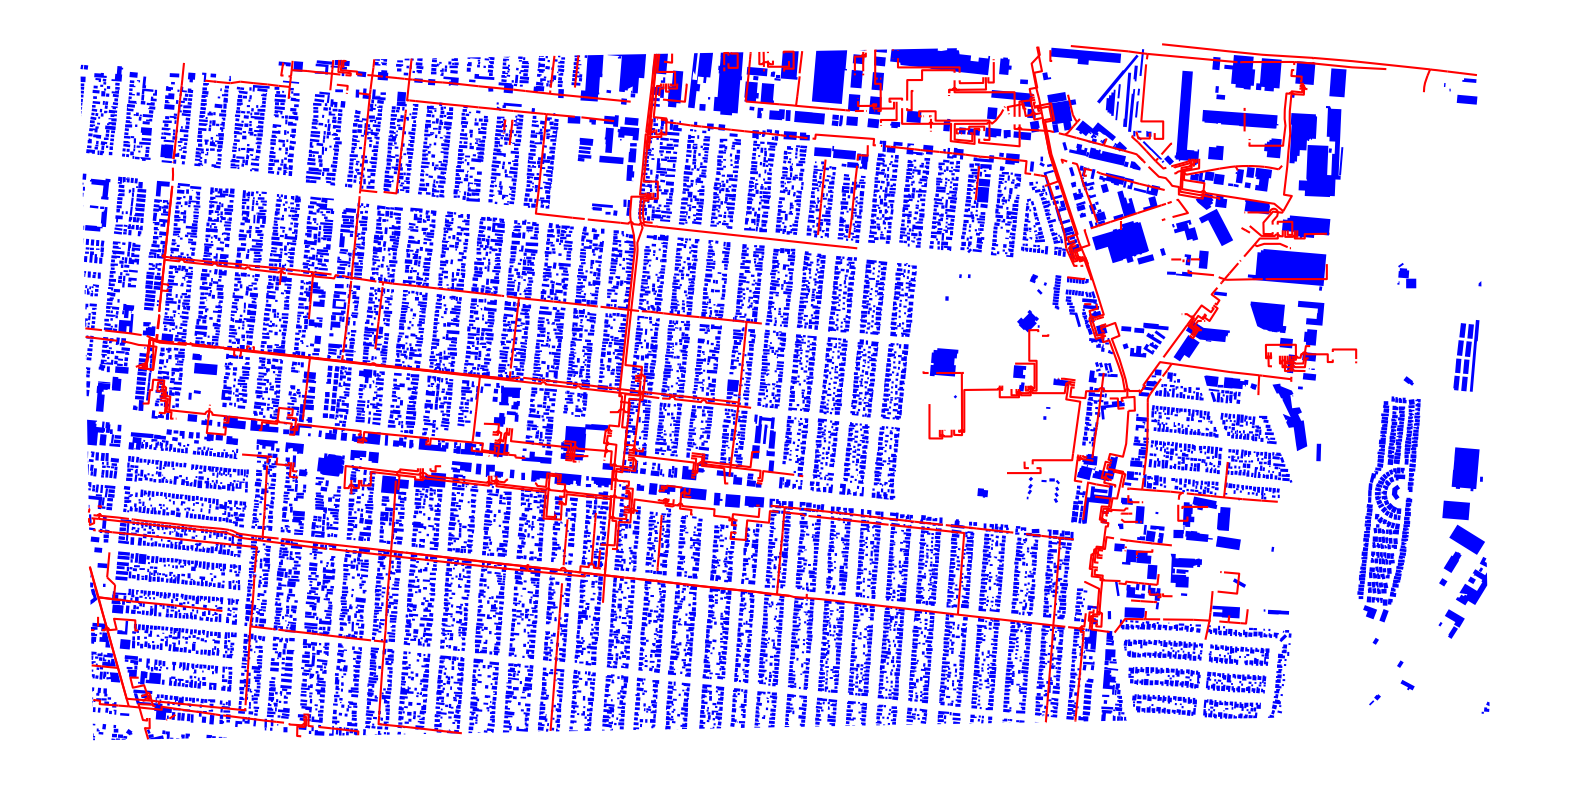

In [16]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.axis('off')

buildings_clip.plot(ax=ax, color='blue')

sce_segments_table.plot(ax=ax, color='red')

# Link data

In [17]:
# Convert building footprints to centroid of building
buildings_clip['geometry'] = buildings_clip.centroid

In [18]:
data_linked = gpd.sjoin_nearest(buildings_clip, sce_segments_table[['circuit_name', 'section_id', 'ica_overall_load', 'substation_name', 'geometry', 'res_pct', 'com_pct', 'agr_pct']], how='left', distance_col='dist_to_line_m')

In [19]:
data_linked.head()

,source,id,height,var,region,bbox,geometry,index_right,circuit_name,section_id,ica_overall_load,substation_name,res_pct,com_pct,agr_pct,dist_to_line_m
4573022,ms,UnitedStates_023012311_832219,2.387687,0.517549,USA,"{'xmin': -118.1729984496768, 'ymin': 33.936795...",POINT (168922.111 -451539.446),547,Cyanide,161450910,4.18,Cudahy,36.07,32.19,0.0,456.487910
4573023,ms,UnitedStates_023012311_307170,0.439230,0.160512,USA,"{'xmin': -118.17212533361956, 'ymin': 33.93705...",POINT (169013.678 -451503.233),547,Cyanide,161450910,4.18,Cudahy,36.07,32.19,0.0,524.252395
4607921,ms,UnitedStates_023012311_1217650,2.483286,0.699443,USA,"{'xmin': -118.1722285390422, 'ymin': 33.937674...",POINT (168991.115 -451439.285),547,Cyanide,161450910,4.18,Cudahy,36.07,32.19,0.0,483.140460
4607922,ms,UnitedStates_023012311_171473,4.941268,1.518147,USA,"{'xmin': -118.17301420371393, 'ymin': 33.93831...",POINT (168916.750 -451369.950),547,Cyanide,161450910,4.18,Cudahy,36.07,32.19,0.0,396.503078
4607923,ms,UnitedStates_023012311_981135,5.603391,0.418036,USA,"{'xmin': -118.1727764737718, 'ymin': 33.938924...",POINT (168941.769 -451292.649),547,Cyanide,161450910,4.18,Cudahy,36.07,32.19,0.0,413.164609


In [20]:
buildings_clip.head()

,source,id,height,var,region,bbox,geometry
4573022,ms,UnitedStates_023012311_832219,2.387687,0.517549,USA,"{'xmin': -118.1729984496768, 'ymin': 33.936795...",POINT (168922.111 -451539.446)
4573023,ms,UnitedStates_023012311_307170,0.439230,0.160512,USA,"{'xmin': -118.17212533361956, 'ymin': 33.93705...",POINT (169013.678 -451503.233)
4607921,ms,UnitedStates_023012311_1217650,2.483286,0.699443,USA,"{'xmin': -118.1722285390422, 'ymin': 33.937674...",POINT (168991.115 -451439.285)
4607922,ms,UnitedStates_023012311_171473,4.941268,1.518147,USA,"{'xmin': -118.17301420371393, 'ymin': 33.93831...",POINT (168916.750 -451369.950)
4607923,ms,UnitedStates_023012311_981135,5.603391,0.418036,USA,"{'xmin': -118.1727764737718, 'ymin': 33.938924...",POINT (168941.769 -451292.649)


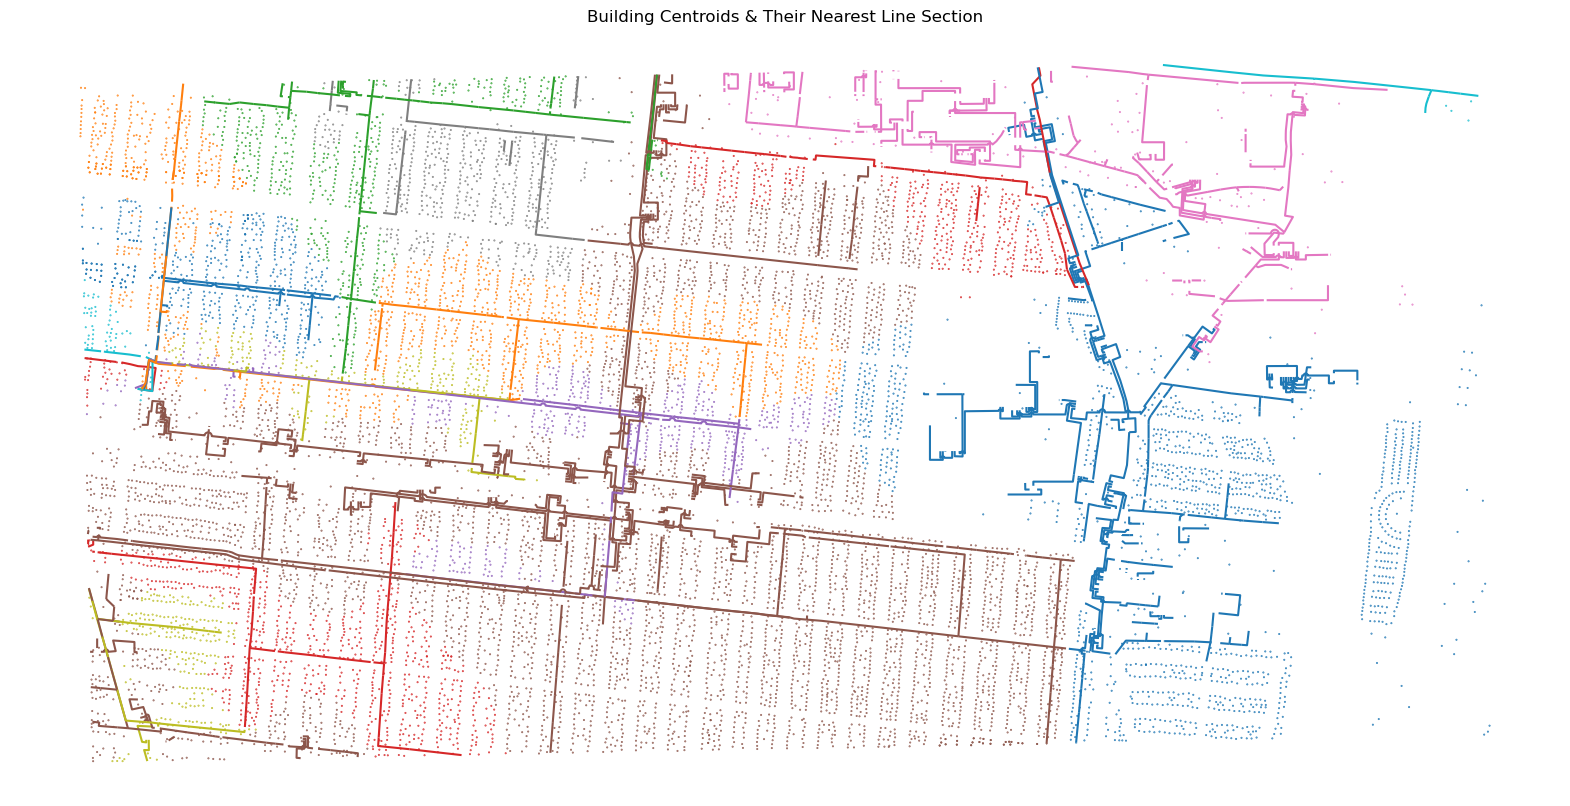

In [21]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.axis('off')

data_linked.plot(ax=ax, column='circuit_name', markersize=0.2)

sce_circ_segments.plot(ax=ax, column='circuit_name')

plt.title("Building Centroids & Their Nearest Line Section")
plt.show()